# Modeling Dengue
This is an assignment for INFO 370 Core Method in Data Science (Autumn 2018) at University of Washington. The task for this project is to measure the **strength of association** between different environmental variables and the number of cases of Dengue. This Jupyter Notebook is a **polished report** of our analysis on Dengue (source of dataset: [link](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread)).


## Problem Overview
   Dengue fever is the leading cause of illness and death in the tropics and subtropics, regions which contain a little more than one-third of the world population. Mild cases of Dengue fever can cause high fever, rash and muscle, and joint pain, while more severe cases can lead to severe bleeding, a sudden drop in blood pressure and death. Dengue is transmitted to people by mosquitoes, and because of this relationship, the disease’s spread spikes yearly when rainfall is optimal for mosquitoe breeding. In fact, this relationship between the disease and the mosquito breeding period is so entwined that, every breeding season Dengue is classified as an epidemic within the tropics and sub-tropics. This relationship between the disease and mosquitoes also means that environmental factors that promote mosquito life will also work as indicators for the spread of Dengue. Limiting exposure to mosquitos in at-risk areas is the only known prevention method for the disease, as a vaccine has yet to be developed. This coupled with the fact that the disease is rapidly spreading, going from having cases in 9 countries in 1970 to over 100 countries by 2015, makes it a high priority for many world health organizations. In order to perform our predictions, we were given access to data from a variety of U.S. Federal Government agencies. 
   
   Citations:
   1. Centers for Disease Control and Prevention. (n.d.). Retrieved from [link](https://www.cdc.gov/).
   2. Here's the ideal temp for mosquito-borne diseases. (2017, May 05). Retrieved from [link](https://www.futurity.org/climate-change-mosquito-diseases-1420452/).
   3. 
   

### Pertinent Variables 
Because dengue is carried by mosquitoes, it’s transmission dynamics are related to climate variables such as temperature and precipitation. To predict the number of dengue fever cases (the `total_cases` label for each `(city, year, weekofyear)` ) based on the provided datasets, it’s important to look at these following information ([source](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/#features_list)):

#### City and Date Indicators
- There are data for _two cities_, San Juan (`sj`) and Iquitos (`iq`) in the `city` column. 
- The date indicator is provided on a `(year, weekofyear, week_start_date)` timescale, which is given in yyyy-mm-dd format.

#### NOAA's GHCN daily climate data weather station measurements
- `station_avg_temp_c` – _Average_ temperature
- `station_precip_mm` – _Total_ precipitation

#### PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)
- `precipitation_amt_mm` – _Total_ precipitation

#### NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)
- `reanalysis_sat_precip_amt_mm` – _Total_ precipitation
- `reanalysis_precip_amt_kg_per_m2` – _Total_ precipitation **(? same as ↾)**
- `reanalysis_dew_point_temp_k` – _Mean_ dew point temperature
- `reanalysis_air_temp_k` – _Mean_ air temperature
- `reanalysis_avg_temp_k` – _Average_ air temperature **(? same as ↾)**
- `reanalysis_relative_humidity_percent` – _Mean_ relative humidity
- `reanalysis_specific_humidity_g_per_kg` – _Mean_ specific humidity


As you can see, there are a few columns that represent the same data point (e.g. `precipitation`) from different sources. Are there any _substantive_ differences from the sources and why would they all be included?

## Set Up

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns # for visualiation
from scipy.stats import ttest_ind # t-tests
from scipy.stats import pearsonr
import statsmodels.formula.api as smf # linear modeling
import statsmodels.api as sm
import matplotlib.pyplot as plt # plotting
import matplotlib
from sklearn import metrics


In [5]:
dengue_features = pd.read_csv("data/dengue_features_train.csv")
dengue_labels = pd.read_csv("data/dengue_labels_train.csv")

## Data Preperation

In [6]:
# Remove all rows with na values
dengue_features = dengue_features.dropna()
# Add column that is average of all three temperature measurements
dengue_features["avg_air_temp_k"] = (dengue_features["reanalysis_air_temp_k"] + dengue_features["reanalysis_avg_temp_k"] + (dengue_features["station_avg_temp_c"] + 273.15)) / 3
merged_data = pd.merge(dengue_features, dengue_labels, on=['city', 'weekofyear', 'year'], how='outer')

merged_data.head()







,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,avg_air_temp_k,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,297.969524,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,298.839524,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,299.174762,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,299.612381,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,300.425238,6


In [9]:
merged_data.isna().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                          257
ndvi_ne                                  257
ndvi_nw                                  257
ndvi_se                                  257
ndvi_sw                                  257
precipitation_amt_mm                     257
reanalysis_air_temp_k                    257
reanalysis_avg_temp_k                    257
reanalysis_dew_point_temp_k              257
reanalysis_max_air_temp_k                257
reanalysis_min_air_temp_k                257
reanalysis_precip_amt_kg_per_m2          257
reanalysis_relative_humidity_percent     257
reanalysis_sat_precip_amt_mm             257
reanalysis_specific_humidity_g_per_kg    257
reanalysis_tdtr_k                        257
station_avg_temp_c                       257
station_diur_temp_rng_c                  257
station_max_temp_c                       257
station_mi

## Exploratory Data Analysis

Below are 5 exploratory visualizations that expose pertinent information about the dataset.

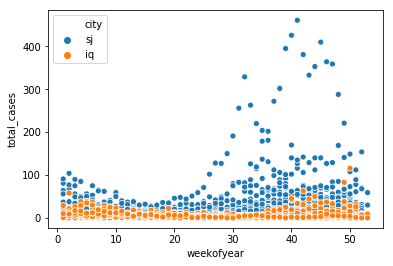

In [42]:
# Scatterplot showing the distribution over times
sns.scatterplot(x="weekofyear", y="total_cases", hue="city", data=dengue_labels)

1. What is the distribution of the number of cases of Dengue each week?

> The above scatterplot shows a **moderate**, **positive**, **non-linear** association between _week of year_ and the number of _total cases_ for both _cities_. <TODO> There appear to be any outliers in the data of San Juan (`sj`).

2. How does the number of cases fluctuate over time? Do these temporal relationships persist in both locations?

> 

3. Which variables are correlated with your outcome of interest (total_cases)? Are these correlations consistent in both cities (you may want to calculate this)?

> 


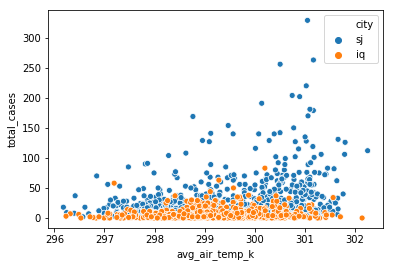

In [43]:
sns.scatterplot(x="avg_air_temp_k", y="total_cases", hue="city", data=merged_data)

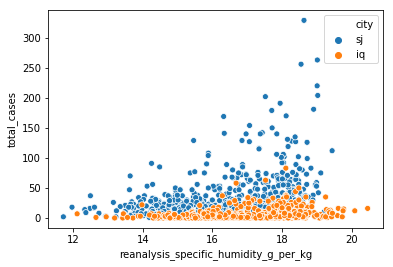

In [57]:
sns.scatterplot(x="reanalysis_specific_humidity_g_per_kg", y="total_cases", hue="city", data=merged_data)

In [59]:
merged_data.corr()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,avg_air_temp_k,total_cases
year,1.000000,-0.071649,0.209123,0.158919,0.249815,0.288012,0.211678,-0.153064,0.078484,0.149605,...,0.211678,0.179731,0.485758,0.048886,0.386740,0.253910,-0.217201,0.221987,-0.013527,-0.306806
weekofyear,-0.071649,1.000000,0.043205,0.041740,0.117256,0.064416,0.091213,0.418064,0.461934,0.323164,...,0.091213,0.325243,0.093306,0.349001,0.041461,0.224172,0.264949,0.053178,0.450440,0.216452
ndvi_ne,0.209123,0.043205,1.000000,0.847277,0.608467,0.661725,0.213507,-0.339393,-0.038229,0.064682,...,0.213507,0.103428,0.672373,0.188121,0.658290,0.490758,-0.308845,0.254844,-0.077043,-0.244080
ndvi_nw,0.158919,0.041740,0.847277,1.000000,0.567478,0.660967,0.210189,-0.324335,-0.031582,0.076656,...,0.210189,0.115136,0.648138,0.201355,0.656392,0.497226,-0.307976,0.237655,-0.064140,-0.210402
ndvi_se,0.249815,0.117256,0.608467,0.567478,1.000000,0.821079,0.088114,-0.160440,0.057714,0.011140,...,0.088114,0.037960,0.495452,0.093499,0.464538,0.301761,-0.259599,0.149273,-0.007799,-0.184491
ndvi_sw,0.288012,0.064416,0.661725,0.660967,0.821079,1.000000,0.131645,-0.228557,0.026154,0.025814,...,0.131645,0.059555,0.571414,0.122542,0.552393,0.386313,-0.300850,0.179338,-0.034886,-0.210784
precipitation_amt_mm,0.211678,0.091213,0.213507,0.210189,0.088114,0.131645,1.000000,-0.055284,0.078630,0.411416,...,1.000000,0.428047,0.220899,0.216333,0.209077,0.303391,0.048827,0.458782,0.084118,-0.037906
reanalysis_air_temp_k,-0.153064,0.418064,-0.339393,-0.324335,-0.160440,-0.228557,-0.055284,1.000000,0.896773,0.500788,...,-0.055284,0.478129,-0.282434,0.595067,-0.270146,0.195801,0.709215,-0.203600,0.917528,0.335022
reanalysis_avg_temp_k,0.078484,0.461934,-0.038229,-0.031582,0.057714,0.026154,0.078630,0.896773,1.000000,0.593459,...,0.078630,0.591450,0.132465,0.732185,0.108517,0.494124,0.562015,-0.066738,0.963586,0.192120
reanalysis_dew_point_temp_k,0.149605,0.323164,0.064682,0.076656,0.011140,0.025814,0.411416,0.500788,0.593459,1.000000,...,0.411416,0.996881,-0.021147,0.723471,0.037057,0.482422,0.627732,0.231150,0.663151,0.179881
